In [187]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, RocCurveDisplay, auc, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

To Do List: 

1. Compare model with and without the cycle indicator using both Penalized Logistic Regression and Gradient Boosting 
2. Metrics used for Model Comparison: ROC and AUC

# Functions

In [287]:
def get_numpy_data(dataframe, features, label):
    features_matrix = dataframe[features].to_numpy()
    label_array = dataframe[label].to_numpy()
    return  features_matrix, label_array

In [301]:
def data_import(file_path, list_to_drop, test_size, random_state):
    
    data = pd.read_csv(file_path).drop(list_to_drop, axis = 1)
    data["spread_derivative"] = pd.to_numeric(data["spread_derivative"], errors = "coerce")
    data.replace([np.inf, -np.inf], np.nan, inplace = True)
    data = data.dropna()
    
    feature_list = data.columns.to_list()
    feature_list.remove("custom_recession_data")
    recession_label = "custom_recession_data"

    feature_matrix, label_array = get_numpy_data(data, feature_list, recession_label)
    x_train, x_test, y_train, y_test = train_test_split(feature_matrix, label_array, test_size = test_size, random_state = random_state)
    return x_train, x_test, y_train, y_test
    

# Data Import

1. Recession Data __with__ Volatility Index and Cycle Indicator (Vix/Spread)

In [310]:
file_path = "updated_final_data.csv"
columns_to_drop = ["Unnamed: 0", "date", "usrecd", "m1sl", "m2sl", "icsa", "mabmm301usm189s",  "bogmbase", "volume", "adj close"]
test_size = 0.3
random_state = 11

x_train_vix, x_test_vix, y_train_vix, y_test_vix = data_import(file_path, columns_to_drop, test_size, random_state)

In [311]:
x_train_vix.shape

(337, 15)

2. Recession Data __without__ Volatility Index and Cycle Indicator (Vix/Spread)

In [312]:
file_path = "updated_final_data.csv"
columns_to_drop = ["Unnamed: 0", "date", "usrecd", "m1sl", "m2sl", "icsa", "mabmm301usm189s",  "bogmbase", "volume", "adj close", "final_vol", "cycle_indicator"]
test_size = 0.3
random_state = 11

x_train, x_test, y_train, y_test = data_import(file_path, columns_to_drop, test_size, random_state)

In [313]:
x_train.shape

(337, 13)

# Logistic Regression with L2 Penalty

In [260]:
from sklearn.preprocessing import PolynomialFeatures, QuantileTransformer, StandardScaler
from sklearn.pipeline import Pipeline as pipe
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, make_scorer

In [261]:
# Logistic Regression Pipe
lr_pipe = pipe([
    ("scale", StandardScaler()),
    ("polynomial", PolynomialFeatures(1)),
    ("model", LogisticRegression(random_state = 11))
])

In [262]:
# Logistic Regression Grid Search
lr_param_grid = [{'model__penalty': ['l1', 'l2'],
                   "model__C": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
                   'model__solver': ['liblinear'],
                 'polynomial__degree': [1, 2, 3, 4]}]

In [199]:
# Grid Search
lr_grid_search = GridSearchCV(estimator=lr_pipe,
        param_grid=lr_param_grid,
        scoring='roc_auc',
        cv=10)

## Logistic Regression for Data with VIX and Cycle Indicator

1. Grid Search for Hyperparameter Tuning

In [167]:
lr_grid_search.fit(x_train_vix, y_train_vix)
df = pd.DataFrame(lr_grid_search.cv_results_)
df

C:\Users\peter\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\peter\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__penalty,param_model__solver,param_polynomial__degree,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001520,0.000813,0.000896,0.000300,0.00001,l1,liblinear,1,"{'model__C': 1e-05, 'model__penalty': 'l1', 'm...",0.500000,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,37
1,0.001881,0.001043,0.001100,0.000536,0.00001,l1,liblinear,2,"{'model__C': 1e-05, 'model__penalty': 'l1', 'm...",0.500000,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,37
2,0.005717,0.000477,0.001708,0.000815,0.00001,l1,liblinear,3,"{'model__C': 1e-05, 'model__penalty': 'l1', 'm...",0.500000,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,37
3,0.023880,0.000973,0.002063,0.000379,0.00001,l1,liblinear,4,"{'model__C': 1e-05, 'model__penalty': 'l1', 'm...",0.500000,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,37
4,0.001512,0.000449,0.001240,0.000520,0.00001,l2,liblinear,1,"{'model__C': 1e-05, 'model__penalty': 'l2', 'm...",0.683333,...,0.606897,0.641379,0.758621,0.751724,0.620690,0.853448,0.706897,0.734138,0.105124,30
5,0.002448,0.000516,0.001045,0.000194,0.00001,l2,liblinear,2,"{'model__C': 1e-05, 'model__penalty': 'l2', 'm...",0.458333,...,0.537931,0.537931,0.627586,0.620690,0.525862,0.715517,0.887931,0.584943,0.133747,35
6,0.008767,0.000603,0.001301,0.000458,0.00001,l2,liblinear,3,"{'model__C': 1e-05, 'model__penalty': 'l2', 'm...",0.541667,...,0.717241,0.786207,0.765517,0.675862,0.741379,0.879310,0.939655,0.742126,0.139698,28
7,0.054911,0.006102,0.002091,0.000528,0.00001,l2,liblinear,4,"{'model__C': 1e-05, 'model__penalty': 'l2', 'm...",0.566667,...,0.772414,0.724138,0.793103,0.565517,0.767241,0.913793,0.913793,0.745029,0.132903,27
8,0.001304,0.000412,0.000891,0.000523,0.0001,l1,liblinear,1,"{'model__C': 0.0001, 'model__penalty': 'l1', '...",0.500000,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,37
9,0.001901,0.000505,0.001351,0.000466,0.0001,l1,liblinear,2,"{'model__C': 0.0001, 'model__penalty': 'l1', '...",0.500000,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,37


2. Creating the Logistic Regression using the Grid Search Results

In [265]:
log_pipe_vix = Pipeline([
    ("scale", StandardScaler()),
    ("polynomial", PolynomialFeatures(1)),
    ("model", LogisticRegression(class_weight = {0: 1, 1:2}, penalty = "l1", C = 1, solver = "liblinear", max_iter = 100))
])

3. Logistic Regression Results on Test-Set

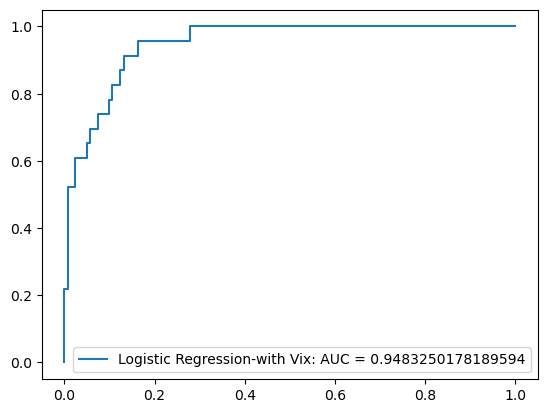

In [314]:
prob = log_pipe_vix.fit(x_train_vix, y_train_vix).predict_proba(x_test_vix)
pred = log_pipe_vix.fit(x_train_vix, y_train_vix).predict(x_test_vix)
fpr, tpr, thresholds = roc_curve(y_test_vix, prob[:, 1], pos_label=1)
auc1 = auc(fpr, tpr)
plt.plot(fpr, tpr, label = "Logistic Regression-with Vix: AUC = " + str(auc1))
plt.legend()

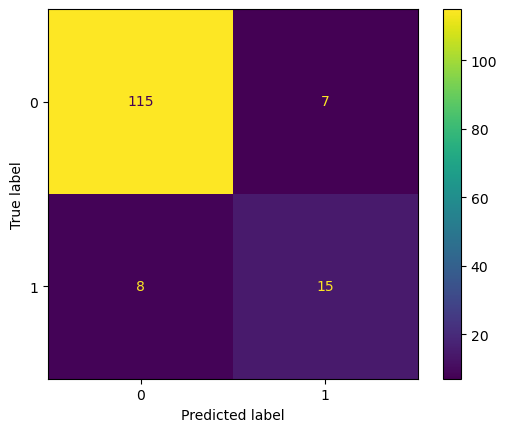

In [315]:
cm = confusion_matrix(y_test_vix, pred)
ConfusionMatrixDisplay(cm).plot()

## Logistic Regression for Data without VIX and Cycle Indicator

In [268]:
lr_grid_search.fit(x_train, y_train)
df = pd.DataFrame(lr_grid_search.cv_results_)
df

KeyboardInterrupt: 

In [269]:
log_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("polynomial", PolynomialFeatures(1)),
    ("model", LogisticRegression(class_weight = {0: 1, 1:2}, penalty = "l1", C = 1, solver = "liblinear", max_iter = 100))
])

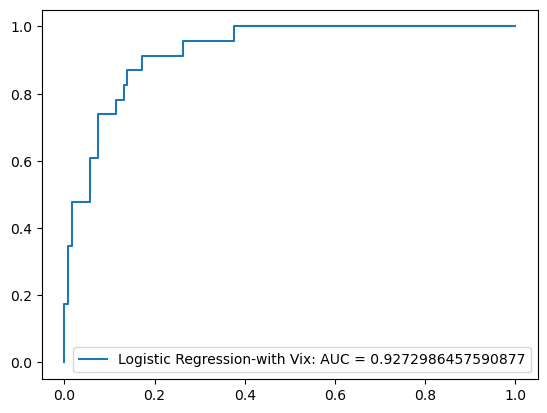

In [316]:
prob = log_pipe.fit(x_train, y_train).predict_proba(x_test)
pred = log_pipe.fit(x_train, y_train).predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, prob[:, 1], pos_label=1)
auc1 = auc(fpr, tpr)
plt.plot(fpr, tpr, label = "Logistic Regression-with Vix: AUC = " + str(auc1))
plt.legend()

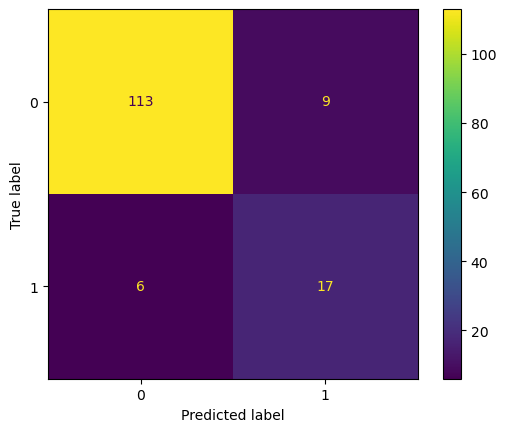

In [271]:
cm = confusion_matrix(y_test, pred)
ConfusionMatrixDisplay(cm).plot()

# Gradient Boosting 

In [231]:
pipe = Pipeline([
    ("scale", StandardScaler()),
    ("polynomial", PolynomialFeatures(1)),
    ("model", GradientBoostingClassifier(random_state = 0))
])

In [240]:
# Logistic Regression Grid Search
lr_param_grid = [{'model__n_estimators': [1,  5,  10, 50, 100],
                   "model__learning_rate": [ 1, 2],
                   'model__max_depth': [1, 3, 5],
                 'polynomial__degree': [1, 2]}]

In [241]:
# Grid Search
lr_grid_search = GridSearchCV(estimator=pipe,
        param_grid=lr_param_grid,
        scoring='roc_auc',
        cv=10)

## Gradient Boosting for Data with VIX and Cycle Indicator

In [242]:
lr_grid_search.fit(x_train, y_train)
df = pd.DataFrame(lr_grid_search.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_polynomial__degree,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001732,0.000594,0.001214,0.000341,1,1,1,1,"{'model__learning_rate': 1, 'model__max_depth'...",0.483333,...,0.582759,0.565517,0.479310,0.500000,0.500000,0.538793,0.431034,0.521178,0.055492,59
1,0.006493,0.002788,0.001561,0.000649,1,1,1,2,"{'model__learning_rate': 1, 'model__max_depth'...",0.466667,...,0.600000,0.600000,0.582759,0.500000,0.625000,0.607759,0.500000,0.593218,0.084143,57
2,0.006426,0.002483,0.001572,0.000804,1,1,5,1,"{'model__learning_rate': 1, 'model__max_depth'...",0.537500,...,0.789655,0.724138,0.637931,0.803448,0.771552,0.741379,0.814655,0.702716,0.093890,37
3,0.027867,0.009157,0.001565,0.001195,1,1,5,2,"{'model__learning_rate': 1, 'model__max_depth'...",0.429167,...,0.689655,0.775862,0.686207,0.448276,0.625000,0.711207,0.758621,0.651940,0.114633,46
4,0.008089,0.002303,0.000951,0.000567,1,1,10,1,"{'model__learning_rate': 1, 'model__max_depth'...",0.558333,...,0.813793,0.868966,0.682759,0.827586,0.831897,0.866379,0.754310,0.758060,0.103387,27
5,0.043287,0.007877,0.001126,0.000336,1,1,10,2,"{'model__learning_rate': 1, 'model__max_depth'...",0.641667,...,0.662069,0.662069,0.772414,0.465517,0.719828,0.931034,0.788793,0.697457,0.115961,38
6,0.033082,0.004735,0.001001,0.000004,1,1,50,1,"{'model__learning_rate': 1, 'model__max_depth'...",0.650000,...,0.972414,0.886207,0.710345,0.965517,0.896552,0.956897,0.931034,0.885287,0.107231,16
7,0.193443,0.014179,0.001606,0.000632,1,1,50,2,"{'model__learning_rate': 1, 'model__max_depth'...",0.833333,...,0.686207,0.717241,0.751724,0.465517,0.767241,0.965517,0.797414,0.731537,0.125244,35
8,0.072882,0.012791,0.001255,0.000337,1,1,100,1,"{'model__learning_rate': 1, 'model__max_depth'...",0.650000,...,0.986207,0.886207,0.710345,0.986207,0.956897,0.974138,0.974138,0.901638,0.115606,13
9,0.404339,0.027075,0.001357,0.000452,1,1,100,2,"{'model__learning_rate': 1, 'model__max_depth'...",0.875000,...,0.686207,0.751724,0.751724,0.465517,0.767241,0.982759,0.797414,0.740876,0.132203,33


In [275]:
gbm_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("polynomial", PolynomialFeatures(1)),
    ("model", GradientBoostingClassifier(learning_rate = 1, max_depth = 3, n_estimators = 100, random_state = 0))
])

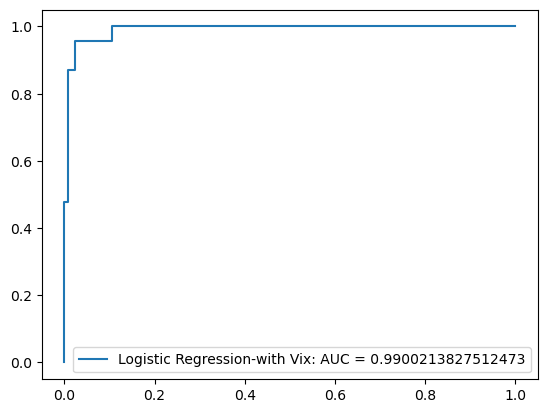

In [317]:
prob = gbm_pipe.fit(x_train, y_train).predict_proba(x_test)
pred = gbm_pipe.fit(x_train, y_train).predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, prob[:, 1], pos_label=1)
auc1 = auc(fpr, tpr)
plt.plot(fpr, tpr, label = "Logistic Regression-with Vix: AUC = " + str(auc1))
plt.legend()

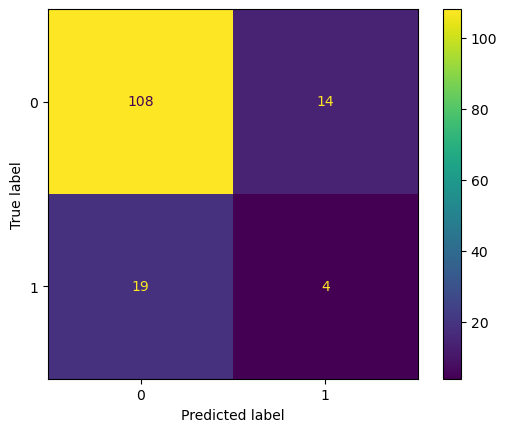

In [309]:
cm = confusion_matrix(y_test, pred)
ConfusionMatrixDisplay(cm).plot()

## Gradient Boosting for Data without VIX and Cycle Indicator

In [278]:
lr_grid_search.fit(x_train_vix, y_train_vix)
df = pd.DataFrame(lr_grid_search.cv_results_)
df

KeyboardInterrupt: 

In [279]:
gbm_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("polynomial", PolynomialFeatures(1)),
    ("model", GradientBoostingClassifier(learning_rate = 1, max_depth = 3, n_estimators = 100, random_state = 0))
])

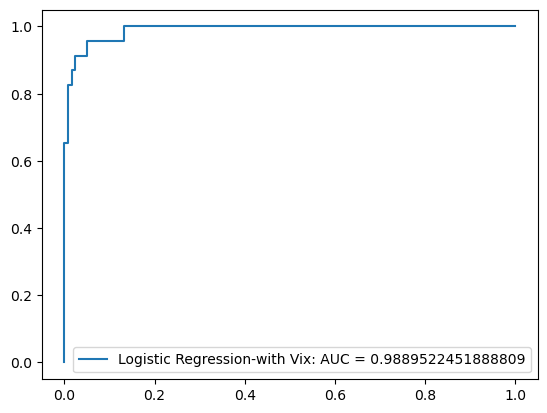

In [318]:
prob = gbm_pipe.fit(x_train_vix, y_train_vix).predict_proba(x_test_vix)
pred = gbm_pipe.fit(x_train_vix, y_train_vix).predict(x_test_vix)
fpr, tpr, thresholds = roc_curve(y_test, prob[:, 1], pos_label=1)
auc1 = auc(fpr, tpr)
plt.plot(fpr, tpr, label = "Logistic Regression-with Vix: AUC = " + str(auc1))
plt.legend()

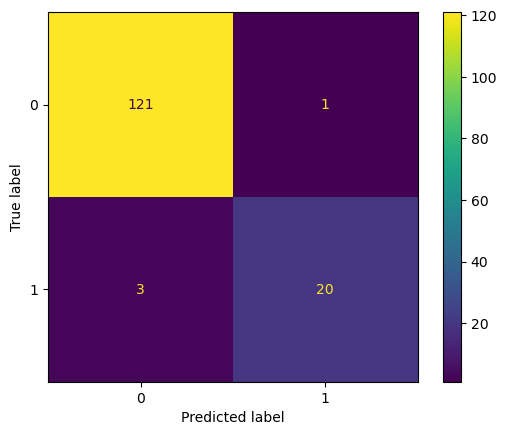

In [281]:
cm = confusion_matrix(y_test, pred)
ConfusionMatrixDisplay(cm).plot()